In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score

In [19]:
df = pd.read_csv("cardio_train.csv", delimiter=";", index_col=0)
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


### Dados limpos, sem valores faltantes. Todas as features são numéricas

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          70000 non-null  int64  
 1   gender       70000 non-null  int64  
 2   height       70000 non-null  int64  
 3   weight       70000 non-null  float64
 4   ap_hi        70000 non-null  int64  
 5   ap_lo        70000 non-null  int64  
 6   cholesterol  70000 non-null  int64  
 7   gluc         70000 non-null  int64  
 8   smoke        70000 non-null  int64  
 9   alco         70000 non-null  int64  
 10  active       70000 non-null  int64  
 11  cardio       70000 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 6.9 MB


### Variável alvo está com valores balanceados

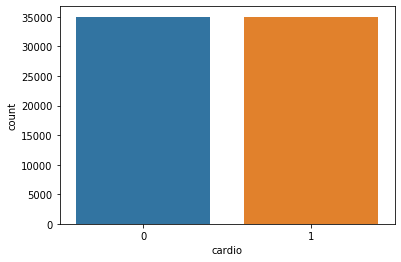

In [21]:
sns.countplot(df.cardio)

### Variáveis numéricas continuas  estão em escalas diferentes. Necessário normalizar. Optei por usar o MinMaxScaler, pois o StandardScaler estava causando NaN no calculo do custo

In [22]:
mmsc = MinMaxScaler()
variaveis_continuas = ["age", "height", "weight", "ap_hi", "ap_lo", "cholesterol"]
df[variaveis_continuas] = mmsc.fit(df[variaveis_continuas]).transform(df[variaveis_continuas])

### Como a variável Sexo é binária, troquei o valor 2 por 0

In [23]:
df.gender.value_counts()

1    45530
2    24470
Name: gender, dtype: int64

In [24]:
df.gender = df.gender.apply(lambda genero: 0 if genero == 2 else genero)

### Train/Test split como modo de validação. Os sets de X foram transpostos de modo que cada coluna seja um exemplo e cada linha seja uma feature

In [26]:
x, y = df.iloc[:,:-1].to_numpy(), df.iloc[:,-1].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
X_train = X_train.T
X_test = X_test.T
y_train = y_train.reshape((1, X_train.shape[1]))
y_test = y_test.reshape((1, X_test.shape[1]))

### Cada layer terá uma matriz de pesos W e um vetor bias b associado. A dimensão da matriz W é definida com a quantidade de linhas sendo igual a quantidade de nodos no layer e a quantidade colunas como a quantidade de inputs do layer. O vetor bias terá um bias para cada nodo layer

In [177]:
def get_parametros_iniciais(tamanho_layers):
    np.random.seed(1)
    parametros = []
    for indice in range(1,len(tamanho_layers)):
        parametros.append([np.random.randn(tamanho_layers[indice], tamanho_layers[indice-1]) * (2/np.sqrt(tamanho_layers[indice-1])),
                           np.zeros((tamanho_layers[indice], 1))])
    return parametros
        

### Definição das funções de ativação utilizadas: sigmóide e relu

In [27]:
def sigmoid(Z):
    A = 1/(1+np.exp(-Z))
    return A

def softsign(Z):
    A = np.divide(Z, (1+np.abs(Z)))
    return A

def relu(Z):
    A = np.maximum(0,Z)
    return A

### Esquema forward propagation
<img src="imagens/model_architecture_kiank.png" style="width:600px;height:300px;">

### O output do layer l é calculado conforme indicado abaixo, sendo A^[0] os dados de treino
$$ A^{[l]} = \theta(  (W^{[l]})^{T} \cdot A^{[l-1]} + b^{[l]}) $$

In [28]:
def forward_propagation(X, parametros, funcao_ativacao=relu):
    cache = []
    A = X
    quantidade_layers = len(parametros)
    for indice_layer in range(0, quantidade_layers-1): # foward propagation até o ultimo layer antes do layer output
        W, b = parametros[indice_layer]
        Z = np.dot(W, A) + b
        cache.append((A, Z, W, b))
        A = funcao_ativacao(Z)
    W, b = parametros[indice_layer+1] # como é um problema de classificao, o último layer deve obrigatoriamente ter
                                      #  a funcao sigmoide como funcao de ativação
    
    Z = np.dot(W, A) + b
    cache.append((A, Z, W, b))
    A = sigmoid(Z)
    
    return A, cache

### A função custo 𝜁 com regularização L2 é definida abaixo, com m sendo a quantidade de exemplos usados no treino: $$\zeta = -\frac{1}{m} \sum\limits_{i = 0}^{m} (y^{(i)}\log\left(A^{[L] (i)}\right) + (1-y^{(i)})\log\left(1- A^{[L](i)}\right)) + \lambda/(2*m)*\sum\limits_{l = 0}^{L} ||W^{(l)})||^{2} $$

In [29]:
def get_custo(A, Y, lambd, parametros):    
    m = Y.shape[1]
    l2 = lambd/(2*m) * np.sum([np.sum(np.square(w)) for w in parametros[:][0]])
    custo = (1./m) * (-np.dot(Y,np.log(A).T) - np.dot(1-Y, np.log(1-A).T)) + l2
    custo = float(np.squeeze(custo))
    return custo

### Os gradientes do layer l são definidos abaixo, sendo L o índice do último layer, A a função de ativação e Z a função linear

$$ \frac{\partial \zeta}{\partial W^{[l]}} = \frac{\partial \zeta}{\partial A^{[L]}} * \prod_{i=L}^{l+1}(\frac{\partial A^{[i]}}{\partial Z^{[i]}}*\frac{\partial Z^{[i]}}{\partial A^{[i-1]}}) * \frac{\partial A^{[l]}}{\partial Z^{[l]}} * \frac{\partial Z^{[l]}}{\partial W^{[l]}} $$

$$ \frac{\partial \zeta}{\partial b^{[l]}} = \frac{\partial \zeta}{\partial A^{[L]}} * \prod_{i=L}^{l+1}(\frac{\partial A^{[i]}}{\partial Z^{[i]}}*\frac{\partial Z^{[i]}}{\partial A^{[i-1]}}) * \frac{\partial A^{[i]}}{\partial Z^{[i]}} * \frac{\partial Z^{[l]}}{\partial b^{[l]}} $$

In [31]:
def derivada_relu(dA, Z):
    dZ = np.array(dA, copy=True) 
    dZ[Z <= 0] = 0
    return dZ

def derivada_softsign(dA, Z):
    return np.multiply(dA, np.divide(1, np.multiply(1+Z, 1+Z)))

def derivada_sigmoide(dA, Z):
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)    
    return dZ

In [182]:
def backward_propagation(A, cache, Y, funcao_ativacao_derivada=derivada_relu):
    m = A.shape[1]
    Y = Y.reshape(A.shape)
    gradientes = []
    
    dA = - (np.divide(Y, A) - np.divide(1 - Y, 1 - A))
    A_prev, Z, W, b = cache[-1]
    dZ = derivada_sigmoide(dA, Z)

    dA_layer_anterior = np.dot(W.T, dZ)
    dW = np.dot(dZ, A_prev.T) / m
    db = np.sum(dZ, axis=1, keepdims=True) / m
    gradientes.append([dW, db])

    for cache_ in cache[::-1][1:]:
        dA = dA_layer_anterior
        A_prev, Z, W, b = cache_
        dZ = funcao_ativacao_derivada(dA, Z)

        dA_layer_anterior = np.dot(W.T, dZ)
        dW = np.dot(dZ, A_prev.T) / m
        db = np.sum(dZ, axis=1, keepdims=True) / m
        gradientes.append([dW, db])
        
    return gradientes[::-1]


### A atualização dos parâmetros do layer l é definido a seguir, sendo alfa a taxa de aprendizado, lambda o coeficiente da regularização L2 e m o tamanho do dataset utilizado no treino
### $$ W^{[l]} = W^{[l]} - \alpha * ( \frac{\partial \zeta}{\partial W^{[l]}} + \lambda/m*W^{[L]})$$
### $$ b^{[l]} = b^{[l]} - \alpha *  \frac{\partial \zeta}{\partial b^{[l]}} $$

In [183]:
def get_parametros_atualizados(parametros, gradientes, m, lambd, taxa_aprendizado=0.05):
    L = len(parametros) 
    for l in range(L):
        parametros[l][0] -= taxa_aprendizado * (gradientes[l][0] + lambd/m * parametros[l][0])
        parametros[l][1] -= taxa_aprendizado * gradientes[l][1] 
    return parametros
    

In [32]:
def fit(X, Y, taxa_aprendizado, iteracoes, tamanhos_layers, lambd=0.7, tamanho_batch=5000):
    global gradientes
    global parametros
    quantidade_batchs = X.shape[1] // tamanho_batch
    
    parametros = get_parametros_iniciais(tamanhos_layers)
    custos = []
    for iteracao in range(iteracoes):
        for batch in range(quantidade_batchs-1):
            x = X[:, tamanho_batch*batch:tamanho_batch*tamanho_batch*(batch+1)]
            y = Y[:, tamanho_batch*batch:tamanho_batch*tamanho_batch*(batch+1)]
            A, cache = forward_propagation(x, parametros)
            custo = get_custo(A, y, lambd, parametros)
            custos.append(custo)
            gradientes = backward_propagation(A, cache, y)
            parametros = get_parametros_atualizados(parametros, gradientes, x.shape[1], lambd, taxa_aprendizado)
        x = X[:,tamanho_batch*(batch+1):]
        y = Y[:, tamanho_batch*(batch+1):]
        A, cache = forward_propagation(x, parametros)
        custo = get_custo(A, y, lambd, parametros)
        custos.append(custo)
        gradientes = backward_propagation(A, cache, y)
        parametros = get_parametros_atualizados(parametros, gradientes, x.shape[1], lambd, taxa_aprendizado)
        if iteracao % 100 == 0:
            print("Iteração: {} | Custo: {}".format(iteracao, custo))
    
    return parametros, custos        

In [186]:
def predict(X, Y, parametros):
    A, cache = forward_propagation(X, parametros)
    return np.round(A)

In [187]:
# def converte_array_em_parametros(array, tamanho_layers):
#     parametros = []
#     for index in range(1, len(tamanho_layers)):
#         w_shape_linear = tamanho_layers[index]*tamanho_layers[index-1]
#         w = array[:w_shape_linear].reshape((tamanho_layers[index], tamanho_layers[index-1]))
#         b = array[w_shape_linear:w_shape_linear + tamanho_layers[index]].reshape((tamanho_layers[index], 1))
#         parametros.append([w, b])
#         array = array[w_shape_linear + tamanho_layers[index]:]
#     return parametros

# def verifica_backpropagation(parametros, gradientes, tamanho_layers, X, Y, epsilon=1e-7):
#     parameters_values = np.concatenate([np.concatenate([parametro[0].flatten(), parametro[1].flatten()]) 
#                                        for parametro in parametros])
#     grads =  np.concatenate([np.concatenate([gradiente[0].flatten(), gradiente[1].flatten()]) 
#                                        for gradiente in gradientes])
    
#     num_parameters = parameters_values.shape[0]
#     J_plus = np.zeros((num_parameters, 1))
#     J_minus = np.zeros((num_parameters, 1))
#     gradapprox = np.zeros((num_parameters, 1))
    
#     for i in range(num_parameters):
        
#         # Compute J_plus[i]. Inputs: "parameters_values, epsilon". Output = "J_plus[i]".
#         # "_" is used because the function you have to outputs two parameters but we only care about the first one
#         ### START CODE HERE ### (approx. 3 lines)
#         thetaplus =  np.copy(parameters_values)                                       # Step 1
#         thetaplus[i] = thetaplus[i] + epsilon                                   # Step 2
#         A, _ =  forward_propagation(X, converte_array_em_parametros(thetaplus, tamanho_layers))  # Step 3
#         J_plus[i][0] = get_custo(A, Y, 0.7, converte_array_em_parametros(thetaplus, tamanho_layers))
#         ### END CODE HERE ###
        
#         # Compute J_minus[i]. Inputs: "parameters_values, epsilon". Output = "J_minus[i]".
#         ### START CODE HERE ### (approx. 3 lines)
#         thetaminus = np.copy(parameters_values)                                       # Step 1
#         thetaminus[i] = thetaminus[i] - epsilon                                 # Step 2       
#         A, _ = forward_propagation(X, converte_array_em_parametros(thetaminus, tamanho_layers)) # Step 3
#         J_minus[i][0] = get_custo(A, Y, 0.7, converte_array_em_parametros(thetaminus, tamanho_layers))
#         ### END CODE HERE ###
        
#         # Compute gradapprox[i]
#         ### START CODE HERE ### (approx. 1 line)
#         gradapprox[i] = (J_plus[i] - J_minus[i]) / (2 * epsilon)
#         ### END CODE HERE ###
    
#     # Compare gradapprox to backward propagation gradients by computing difference.
#     ### START CODE HERE ### (approx. 1 line)
#     numerator = np.linalg.norm(grads - gradapprox)                                     # Step 1'
#     denominator = np.linalg.norm(grads) + np.linalg.norm(gradapprox)                   # Step 2'
#     difference = numerator / denominator                                              # Step 3'
#     ### END CODE HERE ###

#     if difference > 1e-7:
#         print("\033[93m" + "There is a mistake in the backward propagation! difference = " + str(difference) + "\033[0m")
#     else:
#         print("\033[92m" + "Your backward propagation works perfectly fine! difference = " + str(difference) + "\033[0m")
    
#     return difference
    

In [254]:
tamanho_layers = [11, 8, 4, 2, 1]
gradientes = []
parametros = []
parametros, custos = fit(X_train, y_train, 0.05, 1000, tamanho_layers, lambd=0.4, tamanho_batch=4096)

Iteração: 0 | Custo: 0.6934329062095833
Iteração: 100 | Custo: 0.6331354079148583
Iteração: 200 | Custo: 0.630004494681168
Iteração: 300 | Custo: 0.6287941360758122
Iteração: 400 | Custo: 0.6281538550397969
Iteração: 500 | Custo: 0.6274898345505289
Iteração: 600 | Custo: 0.6271929605630615
Iteração: 700 | Custo: 0.6267877682942343
Iteração: 800 | Custo: 0.6263759164013601
Iteração: 900 | Custo: 0.6260934278301121


In [255]:
train_pred = predict(X_train, y_train, parametros)

In [256]:
f1_score(y_train[0], train_pred[0])

0.655976171509715

In [257]:
test_pred = predict(X_test, y_test, parametros)

In [258]:
f1_score(y_test[0], test_pred[0])

0.6610590182018755

In [259]:
accuracy_score(y_test[0], test_pred[0])

0.6488571428571429